# **Causal Inference**
When running a causal inference model, typically you are attempting to identify if some sort of treatment or intervention was effective in changing the outcomes of a particular event or phenomenon. For example, in economic policy, you may want to determine if a government program for first-time homebuyers was effective or not at remediating the housing crisis in your community. In medicine, you may want to see if participating in an exercise program caused people to have better health outcomes or not.

In this notebook, I am applying causal inference to the retail indsutry. In the context of retail, your intervention may be a promotion that you're running on a product, and you're attempting to determine if the promotion was effective in driving an increase in sales or not.

**Scenario:** This dataset was adopted from Kaggle's Store Item Demand Forecasting Challenge dataset (https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data?select=train.csv).  

***In Store 1, store managers noticed that Item 1 isn't selling as much as it used to. On May 31, 2015, the store's leadership decided to run a one-day promotion on the item to see if that would attract more customers to buy the product.***

**Outcome:** By comparing patterns observed during Store 1's promotion to trends observed in stores that were not effected by the promotion, we are able to identify if there is a causal relationship between the promotion and sales. In other words: can we attribute the fluctuations in sales of Item 1 to the promotion? Or are those fluctuations purely by chance?

In [1]:
# import packages
#!pip install pandas
import pandas as pd
import os
import numpy as np
#!pip install jinja2

# stats packages 
#!pip install pycausalimpact
from statsmodels.tsa.arima_process import ArmaProcess
!pip install pycausalimpact
from causalimpact import CausalImpact
import scipy.stats as st
import math

# data viz
import matplotlib.pyplot as plt
#!pip install seaborn
import seaborn as sns

# date/time operations
import datetime

# performance metrics
#!pip install scikit-learn
import sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error 

# change layout of screen
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:75% !important; }</style>"))

os.getcwd()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


'/content'

In [2]:
# import daily pre and post effects
df = pd.read_csv('/content/train_store1_item1.csv')

In [3]:
df.head()
#df.dtypes

,date,intervention_date,store,item,sales
0,1/1/2013,5/31/2015,1,1,13
1,1/2/2013,5/31/2015,1,1,11
2,1/3/2013,5/31/2015,1,1,14
3,1/4/2013,5/31/2015,1,1,13
4,1/5/2013,5/31/2015,1,1,10


In [4]:
# import control time series
# an author for R's causal impact package suggested that a good control time series is that of another set of entities where no treatment was received.
# the idea behind this is that, without intervention, we would expect to see store 1 follow the same patterns as any other store
# using the control regression helps us to see what types of ebs and flows we *would have experienced* had an intervention not occurred - and measure if store 1's results deviated from the expected values
# helpful video explaining this - (first question asked by audience at the end): https://www.youtube.com/watch?v=GTgZfCltMm8
control = pd.read_csv('/content/control_all_other_store_average_daily_sales.csv')
control.head()
control.dtypes

date     object
sales     int64
dtype: object

In [5]:
# convert dates to datetime
df['date'] = pd.to_datetime(df['date'])
control['date'] = pd.to_datetime(control['date'])

# join the control time series to the treatment time series
df = df.merge(control, how='left', on='date')
df.head()

,date,intervention_date,store,item,sales_x,sales_y
0,2013-01-01,5/31/2015,1,1,13,32
1,2013-01-02,5/31/2015,1,1,11,36
2,2013-01-03,5/31/2015,1,1,14,36
3,2013-01-04,5/31/2015,1,1,13,40
4,2013-01-05,5/31/2015,1,1,10,36


In causal inference models, you are generally trying to measure the pre and post effects of a certain event or intervention. The intervention date defines when the action was taken. I chose 5/31/2015 as my intervention date for Store 1.

In [6]:
# convert intervention date to datetime
df['intervention_date'] = pd.to_datetime(df['intervention_date'])
df.dtypes

date                 datetime64[ns]
intervention_date    datetime64[ns]
store                         int64
item                          int64
sales_x                       int64
sales_y                       int64
dtype: object

In [7]:
# the original Kaggle challenge wanted us to predict sales for the next 3 months. I'll use 90 days to be more simple.
# find dates pre/post cutoff dates for both 3 month intervals
# use the [0] position because we need to pass a single value as the upper/lower date bounds in the package parameters
three_months_pre_lower = df['intervention_date'][0] + datetime.timedelta(days=-91)
three_months_pre_upper = df['intervention_date'][0] + datetime.timedelta(days=-1)
three_months_post_lower = df['intervention_date'][0] + datetime.timedelta(days=1) 
three_months_post_upper = df['intervention_date'][0] + datetime.timedelta(days=90)

In [8]:
# sales_x is the sales from store 1. this is what we are trying to predict. that is your "y" value in the causal impact package
# sales_y is the sales from the control regression, or our covariate. that is your "X" value in teh causal impact package
# NOTE: column names and capitalization MATTER when using this package
df = df.rename(columns={'sales_x': 'y','sales_y':'X'})
df.head()

,date,intervention_date,store,item,y,X
0,2013-01-01,2015-05-31,1,1,13,32
1,2013-01-02,2015-05-31,1,1,11,36
2,2013-01-03,2015-05-31,1,1,14,36
3,2013-01-04,2015-05-31,1,1,13,40
4,2013-01-05,2015-05-31,1,1,10,36


In [9]:
# make the date/time the index column
# NOTE: the date column MUST be used as the index column in this package
df = df.set_index('date')
df.head()

,intervention_date,store,item,y,X
date,,,,,
2013-01-01,2015-05-31,1,1,13,32
2013-01-02,2015-05-31,1,1,11,36
2013-01-03,2015-05-31,1,1,14,36
2013-01-04,2015-05-31,1,1,13,40
2013-01-05,2015-05-31,1,1,10,36


In [10]:
# identify pre and post periods for the study

# 90 days pre/post
pre_period = [three_months_pre_lower,three_months_pre_upper]
post_period = [three_months_post_lower,three_months_post_upper] 

In [11]:
print("Pre-period = ",pre_period)
print("Post-period = ",post_period)

Pre-period =  [Timestamp('2015-03-01 00:00:00'), Timestamp('2015-05-30 00:00:00')]
Post-period =  [Timestamp('2015-06-01 00:00:00'), Timestamp('2015-08-29 00:00:00')]


In [12]:
# check for appropriate data types before running model
#df.dtypes

# **Model**

The causalimpact package taakes the following parameters (among others):

- A data frame with the date value as the index
- y: The variable you are attempting to monitor/measure
- X: Your control regressor or covariates


**Helpful Resources:**
- Package: https://pypi.org/project/pycausalimpact/
- Tutorial on how to use this package: https://www.youtube.com/watch?v=GTgZfCltMm8
- Another helpful tutorial: https://practicaldatascience.co.uk/machine-learning/how-to-infer-the-effects-of-marketing-using-the-causal-impact-model
- Source Code: https://github.com/jamalsenouci/causalimpact
- Calculations: https://github.com/jamalsenouci/causalimpact/blob/master/src/causalimpact/inferences.py


In [13]:
# create smaller df with just date index, y column, and X colunm because these are the parameters and structure that are accepted
# by the causalinference package we are using
small_df = df[['y','X']]

#rename to fit into causalimpact params
small_df.head()
small_df = small_df.sort_index(ascending=True) # need to sort this because dates need to be in order

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    25.01              2251.0
Prediction (s.d.)         23.95 (2.55)       2155.69 (229.19)
95% CI                    [18.99, 28.98]     [1709.46, 2607.88]

Absolute effect (s.d.)    1.06 (2.55)        95.31 (229.19)
95% CI                    [-3.97, 6.02]      [-356.88, 541.54]

Relative effect (s.d.)    4.42% (10.63%)     4.42% (10.63%)
95% CI                    [-16.56%, 25.12%]  [-16.56%, 25.12%]

Posterior tail-area probability p: 0.32
Posterior prob. of a causal effect: 68.13%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 25.01. In the absence of an
intervention, we would have expected an average response of 23.95.
The 95% interval of this counterfactual prediction is [18.99, 28.98].
Subtracting this prediction from the obser

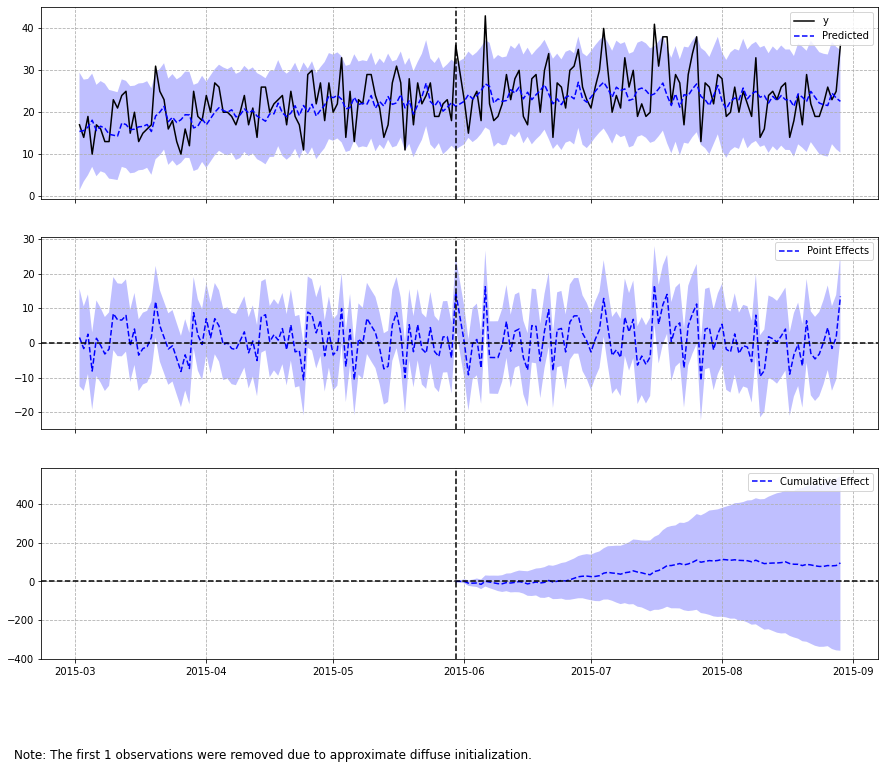

In [14]:
# run model for desired time interval
ci = CausalImpact(small_df, pre_period, post_period, prior_level_sd=None) # prior_level_sd=None was recommended in the documentation

# print visuals and model interpretation output
summary = ci.summary()
report = ci.summary(output='report')
print(ci.summary())
print(ci.summary(output='report'))
ci.plot()

In [15]:
# ci.inferences is where to access the predicted values the model produces
ci = ci.inferences

In [16]:
# take the value prediction, as well as upper and lower bounds and add them to their own data frame
ci = ci[['preds','preds_lower','preds_upper']]
ci.head()

,preds,preds_lower,preds_upper
date,,,
2015-03-01,22.403801,-10855.709949,10900.517551
2015-03-02,15.418058,1.384421,29.451695
2015-03-03,15.615196,3.451478,27.778914
2015-03-04,16.462546,4.984878,27.940214
2015-03-05,18.101141,6.978695,29.223588


In [17]:
# merge predicted values back into original df based on index
merged = df.merge(ci, left_index=True, right_index=True, how='inner')
#merged.head()

In [18]:
# change names of x and y columns back to their original names for readability
merged = merged.rename(columns={'y': 'sales_store1','X':'control'})
merged.head()

,intervention_date,store,item,sales_store1,control,preds,preds_lower,preds_upper
date,,,,,,,,
2015-03-01,2015-05-31,1,1,18,57,22.403801,-10855.709949,10900.517551
2015-03-02,2015-05-31,1,1,17,44,15.418058,1.384421,29.451695
2015-03-03,2015-05-31,1,1,14,41,15.615196,3.451478,27.778914
2015-03-04,2015-05-31,1,1,19,48,16.462546,4.984878,27.940214
2015-03-05,2015-05-31,1,1,10,53,18.101141,6.978695,29.223588


# Additional Forecast Accuracy Metrics

Although forecasting accuracy is not the main focus of performing a causal inference model, you or your audience may want to capture some additional metrics to help ensure the reliability of the conclusions you are making. 

Here, our accuracy metrics are good and show that the model is effective and reliable.

In [19]:
# accuracy metric of predicted v actual values
# Overivew of differences between metrics: https://analyticsindiamag.com/a-guide-to-different-evaluation-metrics-for-time-series-forecasting-models/
y_true = merged['sales_store1']
y_pred = merged['preds']

# calculate MAPE
# value is given as a percentage 
mape = mean_absolute_percentage_error(y_true, y_pred)
print('Mean Absolute Percentage Error (MAPE): %.3f' % mape)
# interpretation of MAPE values: https://stephenallwright.com/good-mape-score/

# calculate r2
r2 = r2_score(y_true, y_pred)
print('R-squared Score: %.3f' % r2)

# calculate MSE
# known as the metric that evaluates the quality of a forecasting model or predictor. 
# MSE also takes into account variance (the difference between anticipated values) and bias (the distance of predicted value from its true value).
# the closer to zero, the better
mse = mean_squared_error(y_true,y_pred)
print('Mean Squared Error (MSE): %.3f' % mse)

# calculate RMSE
# RMSE is in the same units as the predicted value.
# Can compare this to MAE  - The wider the gap between RMSE and MAE, the more erratic the error size
rmse = mean_squared_error(y_true,y_pred, squared=False) # we use the same function that we used to calculate mse, but just set the squared paramater to false (it's default is true)
print('Root Mean Squared Error (RMSE): %.3f' % rmse)

# MAE is defined as the average of the absolute difference between forecasted and true values.
# A value of zero indicates that the forecast is error-free.
# The lower the MAE, the better the model
error = mean_absolute_error(y_true, y_pred)
print('Mean Absolute Error (MAE): %.3f' % rmse)

Mean Absolute Percentage Error (MAPE): 0.213
R-squared Score: 0.203
Mean Squared Error (MSE): 32.588
Root Mean Squared Error (RMSE): 5.709
Mean Absolute Error (MAE): 5.709


In [20]:
merged.describe()

,store,item,sales_store1,control,preds,preds_lower,preds_upper
count,181.0,181.0,181.000000,181.000000,181.000000,181.000000,181.000000
mean,1.0,1.0,22.867403,51.729282,21.895268,-48.983878,92.774414
std,0.0,0.0,6.413882,7.832885,2.970274,807.725207,807.802645
min,1.0,1.0,10.000000,36.000000,14.304223,-10855.709949,24.788008
25%,1.0,1.0,18.000000,46.000000,19.998473,9.532239,30.272452
50%,1.0,1.0,22.000000,52.000000,22.562461,11.446683,33.347007
75%,1.0,1.0,27.000000,57.000000,23.985193,12.818407,35.335106
max,1.0,1.0,43.000000,73.000000,27.162972,16.670006,10900.517551


# **Conclusion:** 

***Based on the results from the causal inference model, fluctuations in sales of Item 1 at Store 1 can not be attributed to the store's promotion.*** 


After reviewing additional model accuracy metrics, store leadership teams can be confident that the models used here accurately guage the relationship between patterns that we saw in Store 1 to patterns that we saw in other stores that did not have the promotion.


Going forward, I would advise that the store may want to consider removing the item from their inventory, or they could explore other strategies to attract more customers to purchase it. We could also consider running the promotion for longer than one day, and/or expand the pre and post periods for longer than 90 days to see if an effect can be captured.

# **Package versions used:**

In [21]:
pip freeze

absl-py==1.2.0
aeppl==0.0.33
aesara==2.7.9
aiohttp==3.8.1
aiosignal==1.2.0
alabaster==0.7.12
albumentations==1.2.1
altair==4.2.0
appdirs==1.4.4
arviz==0.12.1
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
async-timeout==4.0.2
asynctest==0.13.0
atari-py==0.2.9
atomicwrites==1.4.1
attrs==22.1.0
audioread==3.0.0
autograd==1.4
Babel==2.10.3
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==5.0.1
blis==0.7.8
bokeh==2.3.3
branca==0.5.0
bs4==0.0.1
CacheControl==0.12.11
cached-property==1.5.2
cachetools==4.2.4
catalogue==2.0.8
certifi==2022.6.15
cffi==1.15.1
cftime==1.6.1
chardet==3.0.4
charset-normalizer==2.1.1
click==7.1.2
clikit==0.6.2
cloudpickle==1.5.0
cmake==3.22.6
cmdstanpy==1.0.7
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
cons==0.4.5
contextlib2==0.5.5
convertdate==2.4.0
crashtest==0.3.1
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.3.0
cvxpy==1.2.1
cycler==0.11.0
cymem==2.0.6
Cython==0.29.32
daft==0.0.4
dask==2022.2.0
datascience==0.17.5
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.